In [1]:
pip install numpy gym torch stable-baselines3 matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import deque

# Define Grid Environment for UAV Movement
class UAVGridEnv:
    def __init__(self):
        self.grid_size = 3
        self.state_size = self.grid_size * self.grid_size
        self.actions = [0, 1, 2, 3]  # Up, Down, Left, Right
        self.goal_state = (2, 2)
        self.reset()

    def reset(self):
        """ Reset UAV to the start position (0,0) """
        self.uav_pos = (0, 0)
        return self.state_to_vector(self.uav_pos)

    def state_to_vector(self, position):
        """ Convert (x, y) position to a one-hot encoded state vector """
        state = np.zeros(self.state_size)
        index = position[0] * self.grid_size + position[1]
        state[index] = 1
        return state

    def step(self, action):
        """ Move the UAV based on action """
        x, y = self.uav_pos
        if action == 0 and x > 0:  # Move Up
            x -= 1
        elif action == 1 and x < self.grid_size - 1:  # Move Down
            x += 1
        elif action == 2 and y > 0:  # Move Left
            y -= 1
        elif action == 3 and y < self.grid_size - 1:  # Move Right
            y += 1

        self.uav_pos = (x, y)
        reward = 10 if self.uav_pos == self.goal_state else -1
        done = self.uav_pos == self.goal_state
        return self.state_to_vector(self.uav_pos), reward, done

    def render(self, episode, trajectory):
        """ Render the UAV grid environment with real-time visualization """
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(-0.5, self.grid_size - 0.5)
        ax.set_ylim(-0.5, self.grid_size - 0.5)
        ax.set_xticks(range(self.grid_size))
        ax.set_yticks(range(self.grid_size))
        ax.grid(True)

        # Draw goal
        goal_rect = patches.Rectangle((2-0.5, 2-0.5), 1, 1, linewidth=2, edgecolor='green', facecolor='lightgreen')
        ax.add_patch(goal_rect)
        ax.text(2, 2, 'Goal', fontsize=12, ha='center', va='center')

        # Draw UAV trajectory
        for (x, y) in trajectory:
            ax.add_patch(patches.Circle((y, x), 0.2, color='blue'))

        # Draw final UAV position
        ax.add_patch(patches.Circle((self.uav_pos[1], self.uav_pos[0]), 0.3, color='red'))
        ax.text(self.uav_pos[1], self.uav_pos[0], 'UAV', fontsize=10, ha='center', va='center', color='white')

        plt.title(f"UAV Movement (Episode {episode})")
        plt.show()


In [3]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, input_dim, output_dim):
        self.model = DQN(input_dim, output_dim)
        self.target_model = DQN(input_dim, output_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.memory = deque(maxlen=1000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def select_action(self, state):
        """ Choose an action based on epsilon-greedy policy """
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.model.fc3.out_features)
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        return torch.argmax(self.model(state)).item()

    def train(self, batch_size=32):
        """ Train the DQN model using experience replay """
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_model(next_states).max(1)[0]
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def store_experience(self, state, action, reward, next_state, done):
        """ Store experience in the replay buffer """
        self.memory.append((state, action, reward, next_state, done))

    def update_epsilon(self):
        """ Reduce epsilon for better exploitation """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


Episode 1, Total Reward: -8


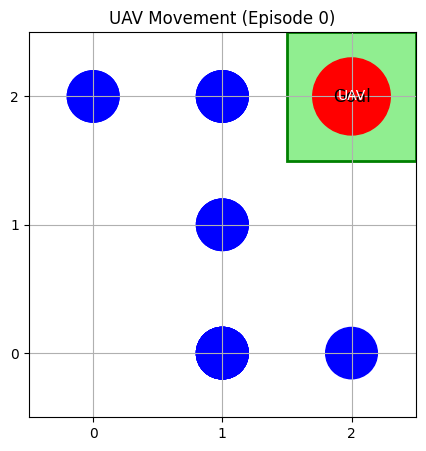

Episode 2, Total Reward: 3
Episode 3, Total Reward: -19


<ipython-input-3-4a1a62435ed9>:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.tensor(states, dtype=torch.float32)


Episode 4, Total Reward: -5
Episode 5, Total Reward: -60
Episode 6, Total Reward: -26
Episode 7, Total Reward: -15
Episode 8, Total Reward: -41
Episode 9, Total Reward: 6
Episode 10, Total Reward: -55
Episode 11, Total Reward: 3


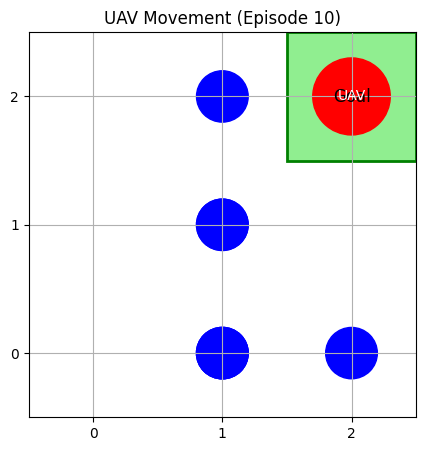

Episode 12, Total Reward: 5
Episode 13, Total Reward: -31
Episode 14, Total Reward: 6
Episode 15, Total Reward: -5
Episode 16, Total Reward: -9
Episode 17, Total Reward: -43
Episode 18, Total Reward: 4
Episode 19, Total Reward: -2
Episode 20, Total Reward: 0
Episode 21, Total Reward: 3


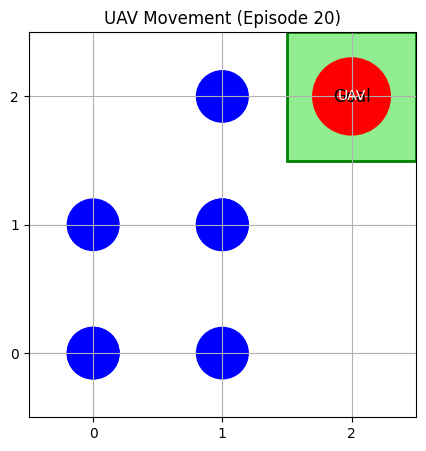

Episode 22, Total Reward: 0
Episode 23, Total Reward: -79
Episode 24, Total Reward: 1
Episode 25, Total Reward: -4
Episode 26, Total Reward: -36
Episode 27, Total Reward: -7
Episode 28, Total Reward: -3
Episode 29, Total Reward: 2
Episode 30, Total Reward: 0
Episode 31, Total Reward: 6


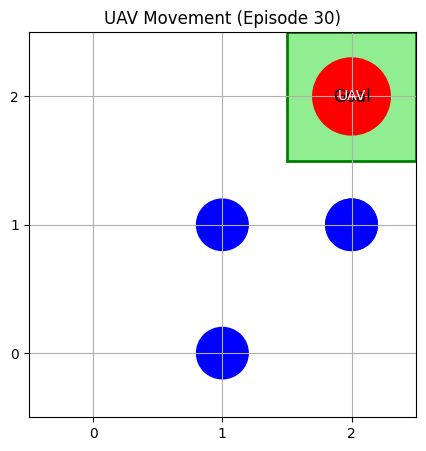

Episode 32, Total Reward: -5
Episode 33, Total Reward: 6
Episode 34, Total Reward: 1
Episode 35, Total Reward: -4
Episode 36, Total Reward: -35
Episode 37, Total Reward: -1
Episode 38, Total Reward: 0
Episode 39, Total Reward: 0
Episode 40, Total Reward: 3
Episode 41, Total Reward: 3


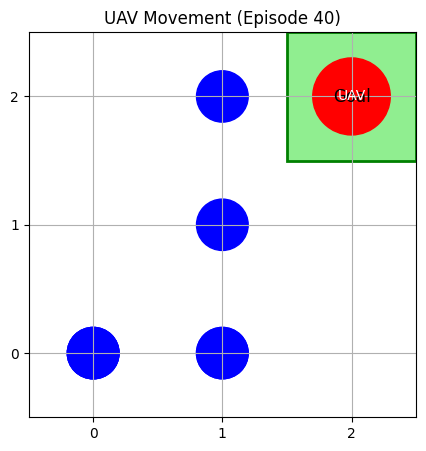

Episode 42, Total Reward: -4
Episode 43, Total Reward: -4
Episode 44, Total Reward: 7
Episode 45, Total Reward: -3
Episode 46, Total Reward: 2
Episode 47, Total Reward: 4
Episode 48, Total Reward: 0
Episode 49, Total Reward: -23
Episode 50, Total Reward: 3


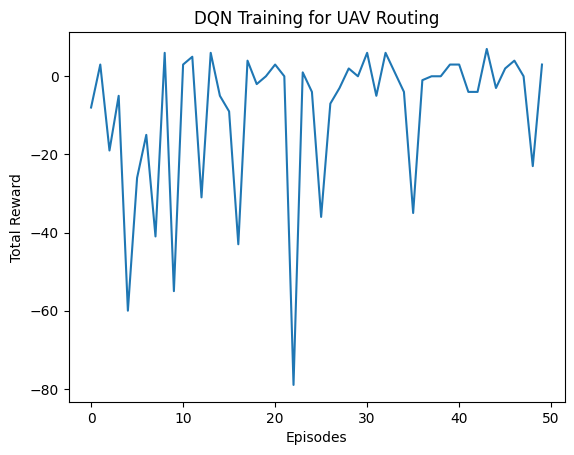

In [4]:
# Initialize Environment & DQN Agent
env = UAVGridEnv()
agent = DQNAgent(input_dim=env.state_size, output_dim=len(env.actions))

num_episodes = 50
reward_history = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    trajectory = []

    while not done:
        action = agent.select_action(state)
        next_state, reward, done = env.step(action)

        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        total_reward += reward

        trajectory.append(env.uav_pos)  # Store trajectory for visualization

    agent.update_epsilon()
    reward_history.append(total_reward)
    print(f"Episode {episode+1}, Total Reward: {total_reward}")

    # Render every 10 episodes
    if episode % 10 == 0:
        env.render(episode, trajectory)

# Plot Training Progress
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("DQN Training for UAV Routing")
plt.show()
